In [628]:
import base

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed

from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from tslearn.clustering import TimeSeriesKMeans

from sklearn.svm import SVC

from transformers_sig import AddTime, LeadLag
from sigKer_fast import mmd_distance

### Load the data

In [83]:
import os
path = '../data/TracerX/'
files = []
outcome_df = pd.read_json('../data/TracerX/outcome.fullCohort.json')
y = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)) and 'CRUK' in i:
        patient_id = i[:8]
        files.append(path + i)
        y.append(outcome_df[outcome_df.ID == patient_id].outcome.values[0])

In [66]:
dataframes = []
for file in tqdm(files):
    dataframes.append(pd.read_json(file).T)

In [74]:
X_ = []
for df in tqdm(dataframes):
    X_.append([np.array([list(d.values()) for d in df.iloc[:,k].values]).T for k in range(len(df.columns))])

### Form trees and reduce number of genes by clustering 

In [596]:
X = []
nb_genes = 4

for t in tqdm(X_, desc='trees loop'):
    
    # find max length of the given tree
    max_len_tree = 0
    for d in t:
        if d.shape[0]>max_len_tree:
            max_len_tree = d.shape[0]
        
    # pad all branches to max length
    tree = []
    for d in t:
        len_to_pad = max_len_tree - d.shape[0]
        branch = np.concatenate([d,np.repeat(d[-1,np.newaxis,:], len_to_pad, axis=0)],axis=0)
        tree.append(branch)
    
    tree = np.array(tree, dtype=np.float64)
#     tree = TimeSeriesScalerMinMax().fit_transform(tree)
    tree = TimeSeriesScalerMeanVariance().fit_transform(tree)

    # select genes within each branch by clustering
    new_tree = []
    for branch in tqdm(tree, desc='branches loop', leave=False):
        clf = TimeSeriesKMeans(n_clusters=nb_genes, metric="euclidean", max_iter=5, random_state=0).fit(branch.T[:,:,None])
        new_tree.append(np.squeeze(clf.cluster_centers_).T)

    X.append(np.array(new_tree))

clustered tree shape: (3, 5, 4)
class: 0


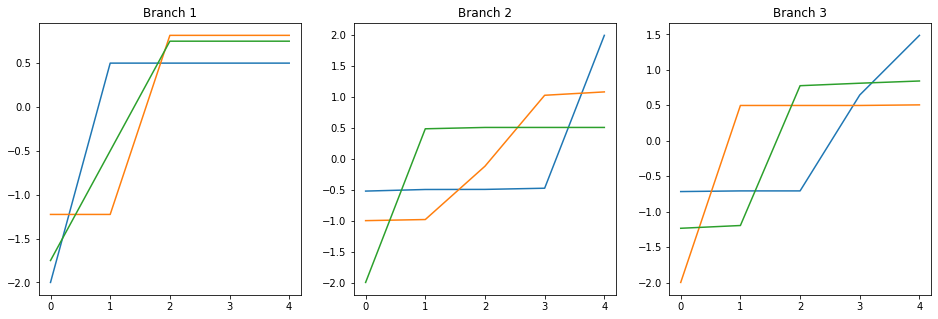

clustered tree shape: (3, 6, 4)
class: 0


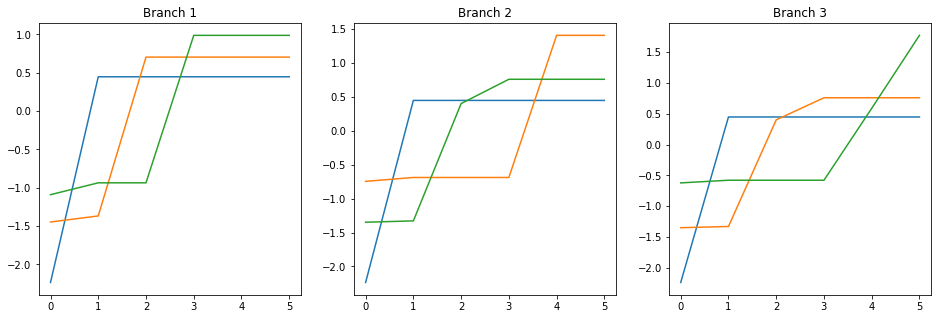

clustered tree shape: (2, 4, 4)
class: 1


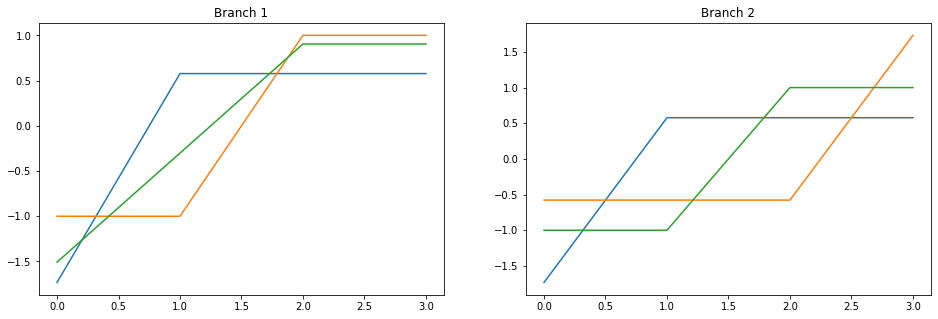

In [597]:
for i in [0,10,20]:

    tree = X[i]
    label = y[i]

    print(f'clustered tree shape: {tree.shape}')
    print(f'class: {label}')

    fig, ax = plt.subplots(1, tree.shape[0], figsize=(16,5))
    for k in range(tree.shape[0]):
        ax[k].plot(tree[k,:,1:])
        ax[k].set_title(f'Branch {k+1}')
    plt.show()

# Inference: kNN and SVC estimators

In [631]:
class TreeKernel(BaseEstimator, TransformerMixin):
    def __init__(self, K_full=None, sigma=1.0):
        super(TreeKernel, self).__init__()
        self.K_full = K_full
        self.sigma = sigma

    def transform(self, ind):
        return np.exp(-self.K_full[ind][:,self.ind_train]/self.sigma)

    def fit(self, ind, y=None, **fit_params):
        self.ind_train = ind
        return self

In [616]:
# data params
N = len(X)

# train test split
ind_train, ind_test, y_train, y_test = train_test_split(np.arange(len(y)), y, test_size=0.2, stratify=y, random_state=42)

# kernel settings
n, solver, rbf = 1, 1, True

# path scalings for kernel
scales = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]

# rbf settings
sigmas = [1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1]

In [627]:
# record results for knn and svc algo
models_dict = {}

for scale in tqdm(scales, desc='1st loop (scales)'):    
    for sigma in tqdm(sigmas, desc='2nd loop (sigmas)', leave=False):
    
        # initialize mmd distance matrix
        K_full = np.zeros((N,N))

        # populate mmd distance matrix
        for i in trange(N, desc='3nd loop', leave=False):
            for j in range(i,N):
                K_full[i,j] = mmd_distance(scale*X[i][:,1:], scale*X[j][:,1:], n=n, solver=solver, rbf=rbf, sigma=sigma) 
        indices = np.tril_indices(N, k=-1, m=N)
        K_full[indices] = K_full.T[indices]

        # train-test split
        x_train = K_full[ind_train, :][:, ind_train]
        x_test = K_full[ind_test, :][:, ind_train]

        # parameters for knn algo
        parameters_knn = {'neigh__n_neighbors': [1,2],
                          'neigh__metric': ['precomputed']}

        # parameters for svm algo
        parameters_svc = {'tree__sigma': np.logspace(-4, 4, 9),
                          'svc__kernel': ['precomputed'],
                          'svc__gamma': np.logspace(4, 4, 9), 
                          'svc__C': np.logspace(0, 4, 5),
                          'svc__class_weight': [{1:3}]}

        # kNN estimator
        neigh = KNeighborsClassifier()
        pipeline_knn = Pipeline([('neigh', neigh)])

        # SVC estimator
        svc = SVC()
        pipeline_svc = Pipeline([('tree', TreeKernel(K_full=K_full)),
                                 ('svc', svc)])

        # model fitting (cv grid-search)
        model_knn = GridSearchCV(pipeline_knn, parameters_knn, verbose=0, n_jobs=-1, cv=5)
        model_svc = GridSearchCV(pipeline_svc, parameters_svc, verbose=0, n_jobs=-1, cv=5)

        model_knn.fit(np.abs(x_train), y_train)
        model_svc.fit(ind_train, y_train)

        models_dict[('knn',scale,sigma)] = model_knn
        models_dict[('svc',scale,sigma)] = model_svc

In [630]:
for scale in scales:
    for sigma in sigmas:
            
        m_knn = models_dict[('knn',scale,sigma)]
        m_svc = models_dict[('svc',scale,sigma)]

        print(f'scale: {scale} ', f'sigma: {sigma} ', 
              f'best score knn: {np.round(m_knn.best_score_,3)} ', 
              f'best score svc: {np.round(m_svc.best_score_,3)} ', '\n')

        y_pred_knn = m_knn.predict(x_test)
        y_pred_svc = m_svc.predict(ind_test)

        print('KNN classification report: \n', classification_report(y_test, y_pred_knn))
        print('KNN confusion matrix: \n', confusion_matrix(y_test, y_pred_knn), '\n\n')
        
        print('SVC classification report: \n', classification_report(y_test, y_pred_svc))
        print('SVC confusion matrix: \n', confusion_matrix(y_test, y_pred_svc), '\n\n\n')

scale: 0.001  sigma: 0.001  best score knn: 0.75  best score svc: 0.763  

KNN classification report: 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.25      0.20      0.22         5

    accuracy                           0.63        19
   macro avg       0.49      0.49      0.49        19
weighted avg       0.61      0.63      0.62        19

KNN confusion matrix: 
 [[11  3]
 [ 4  1]] 


SVC classification report: 
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.40      0.40      0.40         5

    accuracy                           0.68        19
   macro avg       0.59      0.59      0.59        19
weighted avg       0.68      0.68      0.68        19

SVC confusion matrix: 
 [[11  3]
 [ 3  2]] 



scale: 0.001  sigma: 0.01  best score knn: 0.736  best score svc: 0.734  

KNN classification report: 
               pr

KNN classification report: 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.25      0.20      0.22         5

    accuracy                           0.63        19
   macro avg       0.49      0.49      0.49        19
weighted avg       0.61      0.63      0.62        19

KNN confusion matrix: 
 [[11  3]
 [ 4  1]] 


SVC classification report: 
               precision    recall  f1-score   support

           0       0.81      0.93      0.87        14
           1       0.67      0.40      0.50         5

    accuracy                           0.79        19
   macro avg       0.74      0.66      0.68        19
weighted avg       0.77      0.79      0.77        19

SVC confusion matrix: 
 [[13  1]
 [ 3  2]] 



scale: 1.0  sigma: 0.01  best score knn: 0.693  best score svc: 0.805  

KNN classification report: 
               precision    recall  f1-score   support

           0       0.73      0.79     

In [619]:
# # save knn results
# report = classification_report(y_test, y_pred_knn, output_dict=True)
# df = pd.DataFrame(report).transpose()
# df.to_csv(f'../results/TracerX/report__nb_gense_{nb_genes}__sigma_{np.round(sigma,3)}__kNN.csv')

# # save svc results
# report = classification_report(y_test, y_pred_svc, output_dict=True)
# df = pd.DataFrame(report).transpose()
# df.to_csv(f'../results/TracerX/report__nb_gense_{nb_genes}__sigma_{np.round(sigma,3)}__SVC.csv')